In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.1 MB/s eta 0:00:00


In [2]:
!pip install xarray==2024.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2024.10.0
    Uninstalling xarray-2024.10.0:
      Successfully uninstalled xarray-2024.10.0


**This code was executed in Google Colab.**

In [3]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import pandas as pd

import matplotlib
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import xgboost as xgb
import scipy

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import platform
import sys

print("Operating System:", platform.system(), platform.release())
print("Python Version:", sys.version)

print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)
print("Matplotlib Version:", matplotlib.__version__)
print("Seaborn Version:", sns.__version__)
print("Scikit-Learn Version:", sklearn.__version__)
print("XGBoost Version:", xgb.__version__)
print("xarray Version:", xr.__version__)
print("scipy Version:", scipy.__version__)
print("Cartopy Version:", cartopy.__version__)

Operating System: Linux 6.1.85+
Python Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Pandas Version: 2.2.2
NumPy Version: 1.26.4
Matplotlib Version: 3.8.0
Seaborn Version: 0.13.2
Scikit-Learn Version: 1.5.2
XGBoost Version: 2.1.2
xarray Version: 2024.9.0
scipy Version: 1.13.1
Cartopy Version: 0.24.1


In [5]:
!pip list --format=freeze > storm_atmos.txt

# Functions

In [6]:
def plotRegion(data,
               XC,
               YC,
               levelf,
               proj=ccrs.PlateCarree(central_longitude=160),
               contour=False,
               cmap='bwr',
               title=' '):
    plt.figure(figsize=(10, 4), facecolor='w')
    ax = plt.axes(projection=proj)
    ax.set_extent([50, 80, -15, -5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='gray', zorder=100, edgecolor='k')
    ax.coastlines(color='k')

    # Shading and contour
    cm = ax.contourf(XC, YC, data, levels=levelf,
                     transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    if contour:
        c0 = ax.contour(XC, YC, data, colors='gray', levels=[0],
                        transform=ccrs.PlateCarree(), linewidths=1.5)
        ax.clabel(c0, fmt='%2.1f', colors='gray', fontsize=10)
        ct = ax.contour(XC, YC, data, colors='k', levels=levelt,
                        transform=ccrs.PlateCarree(), linewidths=1.5)
        ax.clabel(ct, fmt='%2.1f', colors='k', fontsize=10)

    # Grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.6, color='black', alpha=0.4, linestyle='--',
                      x_inline=False, y_inline=False)
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(-15, -4.1, 1))
    gl.xlabel_style = {'rotation': 0, 'fontsize': 8}
    gl.ylabel_style = {'rotation': 0, 'fontsize': 8}
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.bottom_labels = True

    # Title
    plt.title(title, fontsize=14)
    # Color bar with adjusted thickness
    cbar = plt.colorbar(cm, orientation='horizontal', pad=0.1, shrink=0.7)
    cbar.ax.tick_params(labelsize=8)
    plt.show()

In [7]:
def plotRegion_wind(u_wind, v_wind, wind_speed, n,
               XC,
               YC,
               levelf,
               proj=ccrs.PlateCarree(central_longitude=160),
               contour=False,
               cmap='bwr',
               title=' '):
    plt.figure(figsize=(10, 4), facecolor='w')
    ax = plt.axes(projection=proj)
    ax.set_extent([50, 80, -15, -5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='gray', zorder=100, edgecolor='k')
    ax.coastlines(color='k')

    # wind speed
    cm = ax.contourf(XC, YC, wind_speed, levels=levelf,
                     transform=ccrs.PlateCarree(), cmap=cmap, extend='both')

    # wind vector
    q = ax.quiver(XC[::n], YC[::n], u_wind[::n, ::n], v_wind[::n, ::n],
                  transform=ccrs.PlateCarree(), pivot='middle', color='black',
                  scale=200)
    ax.quiverkey(q, X=0.9, Y=-0.2, U=1, label='1 m/s', labelpos='E', coordinates='axes')

    # Grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.65, color='black', alpha=0.4, linestyle='--',
                      x_inline=False, y_inline=False)
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(-15, -4.1, 1))
    gl.xlabel_style = {'rotation': 0, 'fontsize': 8}
    gl.ylabel_style = {'rotation': 0, 'fontsize': 8}
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.bottom_labels = True

    # Title
    plt.title(title, fontsize=14)
    cbar = plt.colorbar(cm, orientation='horizontal', pad=0.1, shrink=0.6)
    cbar.ax.tick_params(labelsize=8)
    plt.show()

# EDA

In [8]:
# Modify this base_dir path as needed for the verification environment.

from google.colab import drive
drive.mount('/content/drive')

adir = '/content/drive/MyDrive/ocean_contest/oceanct/'  # Change as necessary for your environment

Mounted at /content/drive


In [9]:
os_info = platform.system()
current_dir = os.getcwd()
print(f"Current OS: {os_info}")
print(f"Current working directory: {current_dir}")
print(f"Base directory: {adir}")

# Current OS: Linux
# Current working directory: /content
# Base directory: /content/drive/MyDrive/ocean_contest/oceanct/

Current OS: Linux
Current working directory: /content
Base directory: /content/drive/MyDrive/ocean_contest/oceanct/


### given data d20

In [10]:
# Data load
### d20 ###
f_d20 = xr.open_dataset(adir+'EN.4.2.2_D20_SCTR_f.nc') # 199101-202404
d20 = f_d20['D20_SCTR']
d20 = d20.rename({'TIME1': 'time'})
d20['time'] = (d20['time'].astype(str).str[:7]).astype(np.datetime64)

<ipython-input-10-af0e3d2a555a>:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  d20['time'] = (d20['time'].astype(str).str[:7]).astype(np.datetime64)


### variables
(https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [11]:
f_wind = xr.open_dataset(adir+'ERA5_wind.nc')
print(f_wind['time'])

windspeed = f_wind.var207
u10 = f_wind.var165
v10 = f_wind.var166

<xarray.DataArray 'time' (time: 404)> Size: 3kB
array(['1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-03-01T00:00:00.000000000', ..., '2024-06-01T00:00:00.000000000',
       '2024-07-01T00:00:00.000000000', '2024-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2024-08-01
Attributes:
    standard_name:  time
    axis:           T


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


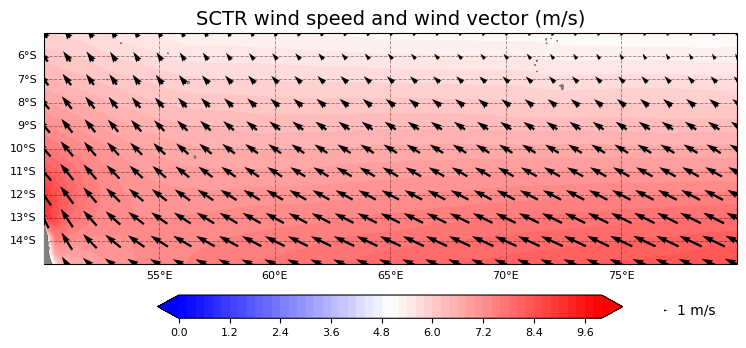

In [12]:
plotRegion_wind(np.nanmean(u10, axis=0), np.nanmean(v10, axis=0), np.nanmean(windspeed, axis=0), 4,
               XC=windspeed.lon.data,
               YC=windspeed.lat.data,
               levelf=np.arange(0, 10.1, 0.2),
               title='SCTR wind speed and wind vector (m/s)')

In [13]:
u10_5 = u10.sel(lat=-5)
u10_15 = u10.sel(lat=-15)
v_current = (u10_15 - u10_5).mean(dim=['lon'])

v10_50 = v10.sel(lon=50)
v10_80 = v10.sel(lon=80)
u_current = (v10_50 - v10_80).mean(dim=['lat'])

In [14]:
f_variables = xr.open_dataset(adir+'ERA5_variables.nc')
print(f_variables['time'])
sst = f_variables.var34 -273.15
precip_rate = f_variables.var55 * 86400
latent_heatflux = f_variables.var34_2
longwave_rad = f_variables.var38
shortwave_rad = f_variables.var37
sensible_heatflux = f_variables.var33
total_heatflux = latent_heatflux + longwave_rad + shortwave_rad + sensible_heatflux

<xarray.DataArray 'time' (time: 404)> Size: 3kB
array(['1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-03-01T00:00:00.000000000', ..., '2024-06-01T00:00:00.000000000',
       '2024-07-01T00:00:00.000000000', '2024-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2024-08-01
Attributes:
    standard_name:  time
    axis:           T


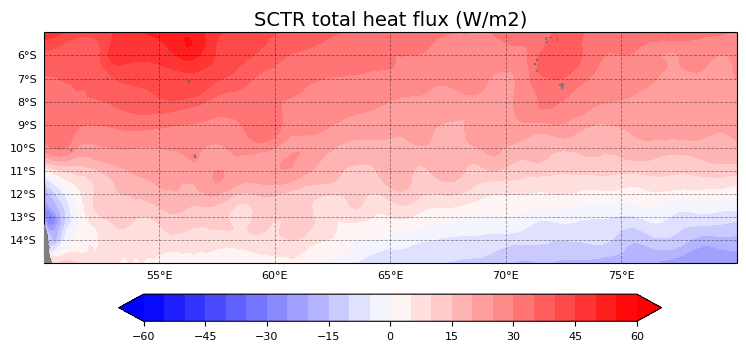

In [15]:
plotRegion(np.nanmean(total_heatflux, axis=0),
           XC=windspeed.lon.data,
           YC=windspeed.lat.data,
           levelf=np.arange(-60, 60.1, 5),
           title='SCTR total heat flux (W/m2)')

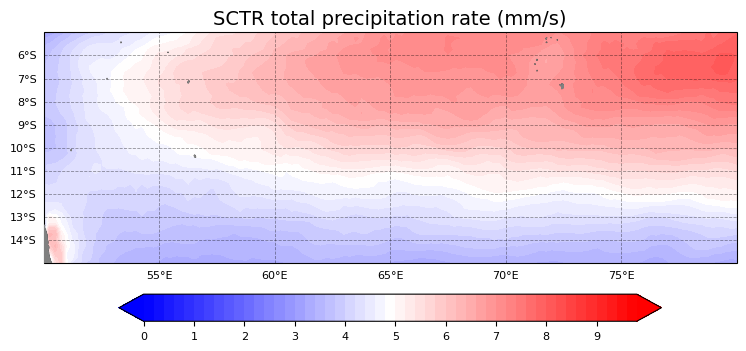

In [16]:
plotRegion(np.nanmean(precip_rate, axis=0),
           XC=windspeed.lon.data,
           YC=windspeed.lat.data,
           levelf=np.arange(0, 10, 0.2),
           title='SCTR total precipitation rate (mm/s)')

<ipython-input-17-92b46aeacd17>:1: RuntimeWarning: Mean of empty slice
  plotRegion(np.nanmean(sst, axis=0),


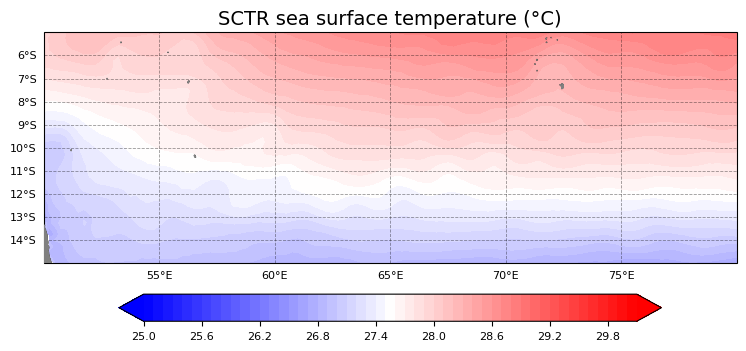

In [17]:
plotRegion(np.nanmean(sst, axis=0),
           XC=windspeed.lon.data,
           YC=windspeed.lat.data,
           levelf=np.arange(25, 30.1, 0.1),
           title='SCTR sea surface temperature (°C)')

### spatial average

In [18]:
ws_avg = windspeed.mean(dim=['lat','lon'])
u10_avg = u10.mean(dim=['lat','lon'])
v10_avg = v10.mean(dim=['lat','lon'])
sst_avg = sst.mean(dim=['lat','lon'])
prep_avg = precip_rate.mean(dim=['lat','lon'])
latent_avg = latent_heatflux.mean(dim=['lat','lon'])
lwrad_avg = longwave_rad.mean(dim=['lat','lon'])
swrad_avg = shortwave_rad.mean(dim=['lat','lon'])
sensible_avg = sensible_heatflux.mean(dim=['lat','lon'])
totalhf_avg = total_heatflux.mean(dim=['lat','lon'])

Text(0.5, 1.0, 'd20')

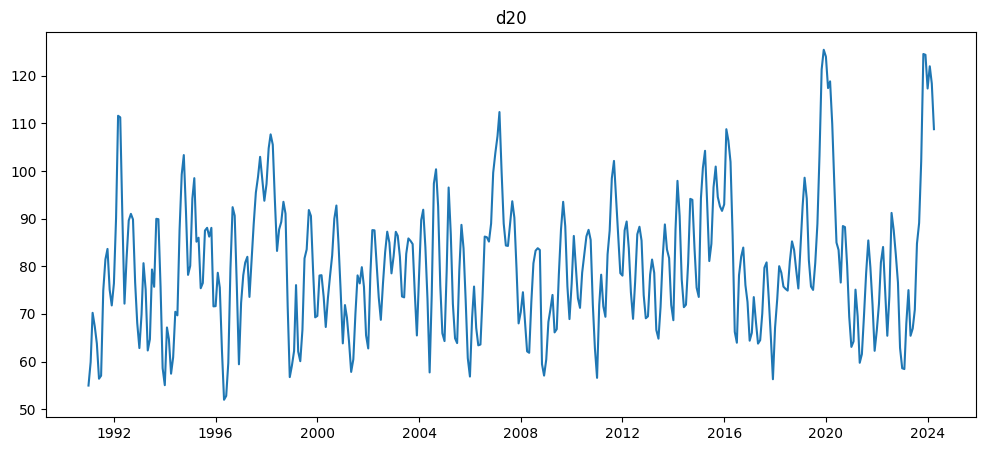

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(d20.time, d20)
plt.title('d20')

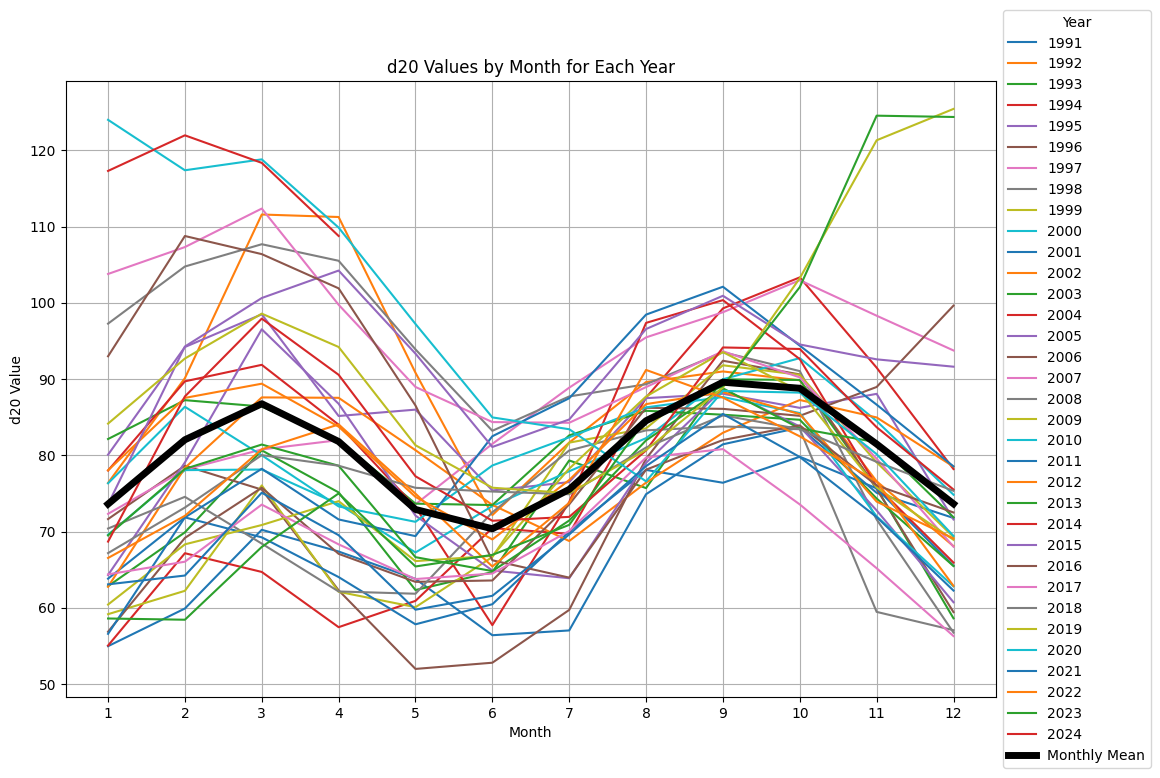

In [20]:
d20_fig = d20.copy()

d20_fig = d20_fig.assign_coords(year=("time", d20_fig['time.year'].values))
d20_fig = d20_fig.assign_coords(month=("time", d20_fig['time.month'].values))

d20_df = d20_fig.to_dataframe().reset_index()
d20_monthlymean = d20_df.groupby('month')['D20_SCTR'].mean()

plt.figure(figsize=(12, 8))

for year in d20_df['year'].unique():
    yearly_data = d20_df[d20_df['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['D20_SCTR'], label=str(year))
plt.plot(d20_monthlymean.index, d20_monthlymean.values, label='Monthly Mean', linewidth=5, color='black')

plt.title('d20 Values by Month for Each Year')
plt.xlabel('Month')
plt.ylabel('d20 Value')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

d20_fig = d20_fig.drop_vars(['year', 'month'])

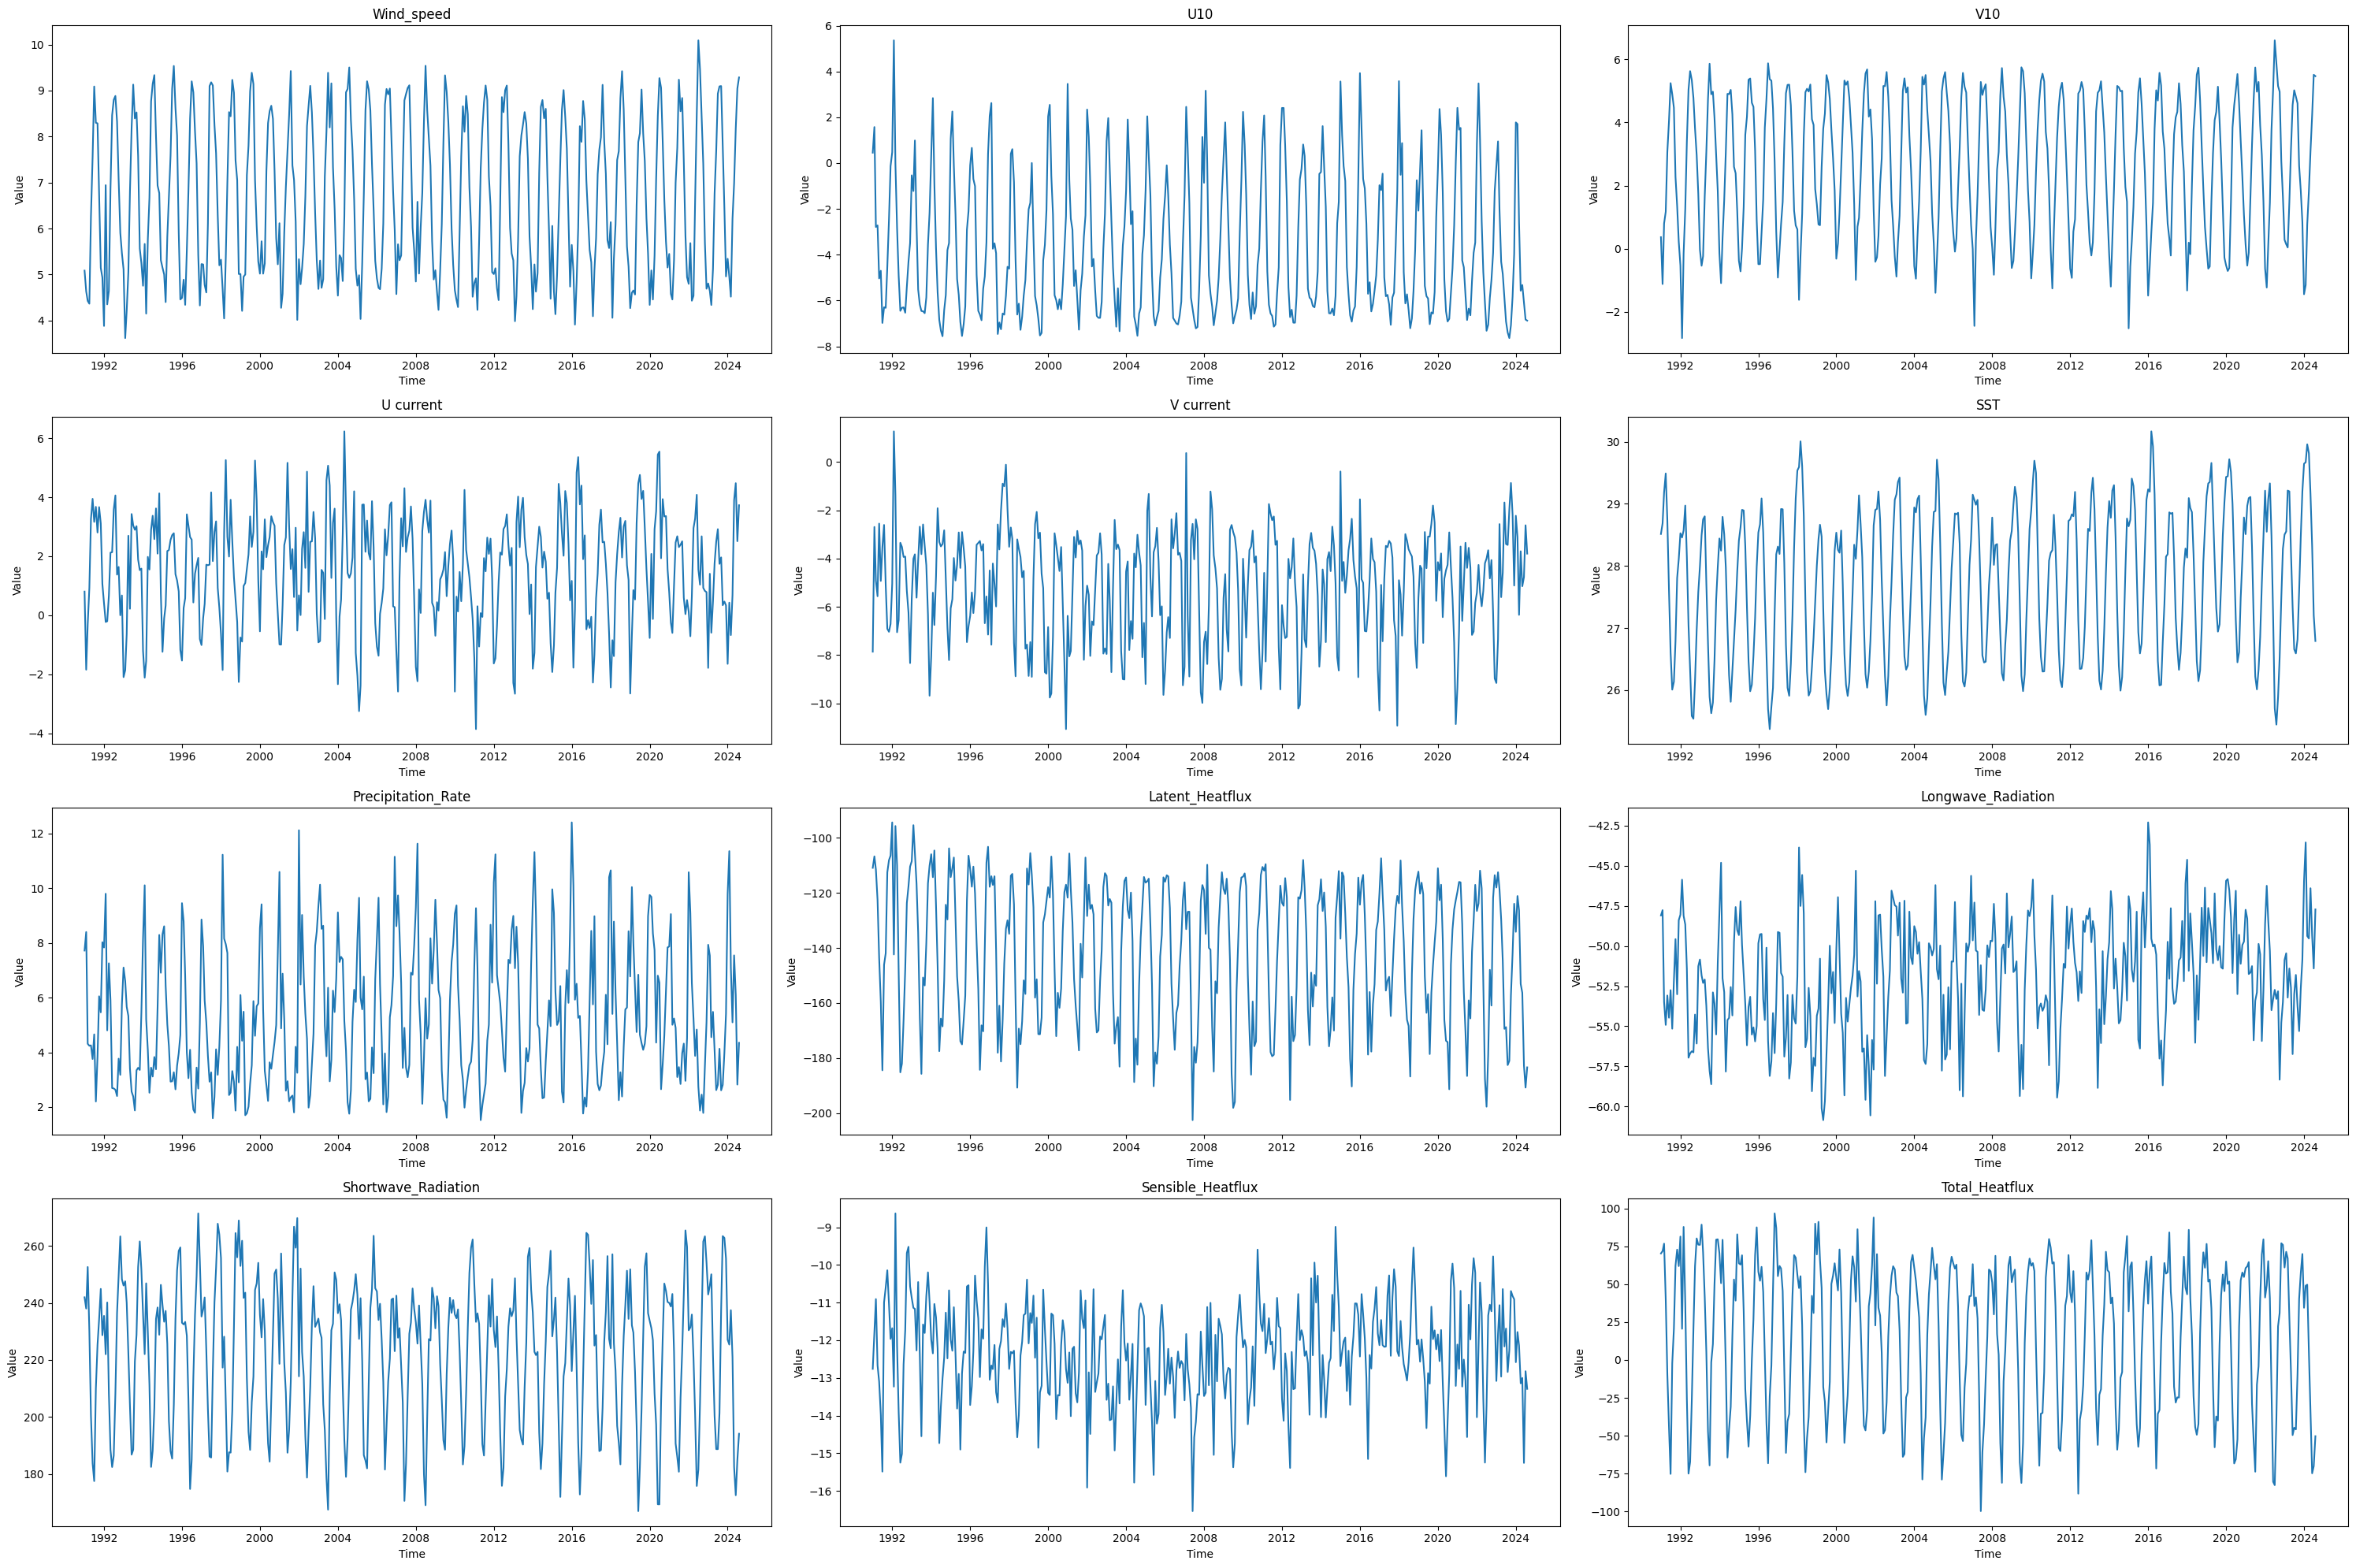

In [21]:
fig, axs = plt.subplots(4, 3, figsize=(30, 20))
variables = [
    (ws_avg.copy(), 'Wind_speed'),
    (u10_avg.copy(), 'U10'),
    (v10_avg.copy(), 'V10'),
    (u_current.copy(), 'U current'),
    (v_current.copy(), 'V current'),
    (sst_avg.copy(), 'SST'),
    (prep_avg.copy(), 'Precipitation_Rate'),
    (latent_avg.copy(), 'Latent_Heatflux'),
    (lwrad_avg.copy(), 'Longwave_Radiation'),
    (swrad_avg.copy(), 'Shortwave_Radiation'),
    (sensible_avg.copy(), 'Sensible_Heatflux'),
    (totalhf_avg.copy(), 'Total_Heatflux')
]

for ax, (var, title) in zip(axs.flatten(), variables):
    var.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [22]:
legend_ax_index = 0

fig, axs = plt.subplots(4, 3, figsize=(30, 20))

handles = []
labels = []

for i, (ax, (var, title)) in enumerate(zip(axs.flatten(), variables)):
    var.name = title

    var = var.assign_coords(year=("time", var['time.year'].values))
    var = var.assign_coords(month=("time", var['time.month'].values))

    var_df = var.to_dataframe().reset_index()

    monthly_mean = var_df.groupby('month')[var.name].mean()

    for year in var_df['year'].unique():
        yearly_data = var_df[var_df['year'] == year]
        line, = ax.plot(yearly_data['month'], yearly_data[var.name], label=str(year))
        if i == legend_ax_index:
            handles.append(line)
            labels.append(f"{year}")

    mean_line, = ax.plot(monthly_mean.index, monthly_mean.values, label='Monthly Mean', linewidth=5, color='black')

    if i == legend_ax_index:
        handles.append(mean_line)
        labels.append(f"Monthly Mean")

    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')
    ax.set_xticks(range(1, 13))
    ax.grid()
    var = var.drop_vars(['year', 'month'])

fig.legend(handles, labels, title='Year and Monthly Mean', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### climate index (https://psl.noaa.gov/data/timeseries/month/)

In [23]:
# Data load
### climate index ###
f_ao = xr.open_dataset(adir+'ao.long.nc')
f_dmi = xr.open_dataset(adir+'dmi.nc')
f_mei = xr.open_dataset(adir+'meiv2.nc')
f_nao = xr.open_dataset(adir+'nao.long.nc')
f_pdo = xr.open_dataset(adir+'pdo.timeseries.cobe2-sst.nc')
f_soi = xr.open_dataset(adir+'soi.long.nc')

In [24]:
ao = f_ao['value'].sel(time=slice('1991-01-01', None))
dmi = f_dmi['DMI'].resample(TIME='1M').mean().sel(TIME=slice('1991-01-01', None))
mei = f_mei['value'].sel(time=slice('1991-01-01', None))
nao = f_nao['value'].sel(time=slice('1991-01-01', None))
pdo = f_pdo['pdo'].sel(time=slice('1991-01-01', None))
soi = f_soi['value'].sel(time=slice('1991-01-01', None))

dmi = dmi.rename({'TIME': 'time'})
dmi['time'] = (dmi['time'].astype(str).str[:7]).astype(np.datetime64)

ao = xr.DataArray(ao.values, coords=[ao.time], dims=["time"], name="ao")
mei = xr.DataArray(mei.values, coords=[mei.time], dims=["time"], name="mei")
nao = xr.DataArray(nao.values, coords=[nao.time], dims=["time"], name="nao")
pdo = xr.DataArray(pdo.values, coords=[pdo.time], dims=["time"], name="pdo")
soi = xr.DataArray(soi.values, coords=[soi.time], dims=["time"], name="soi")

/usr/local/lib/python3.10/dist-packages/xarray/groupers.py:403: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
<ipython-input-24-3fb6a01762c3>:9: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dmi['time'] = (dmi['time'].astype(str).str[:7]).astype(np.datetime64)


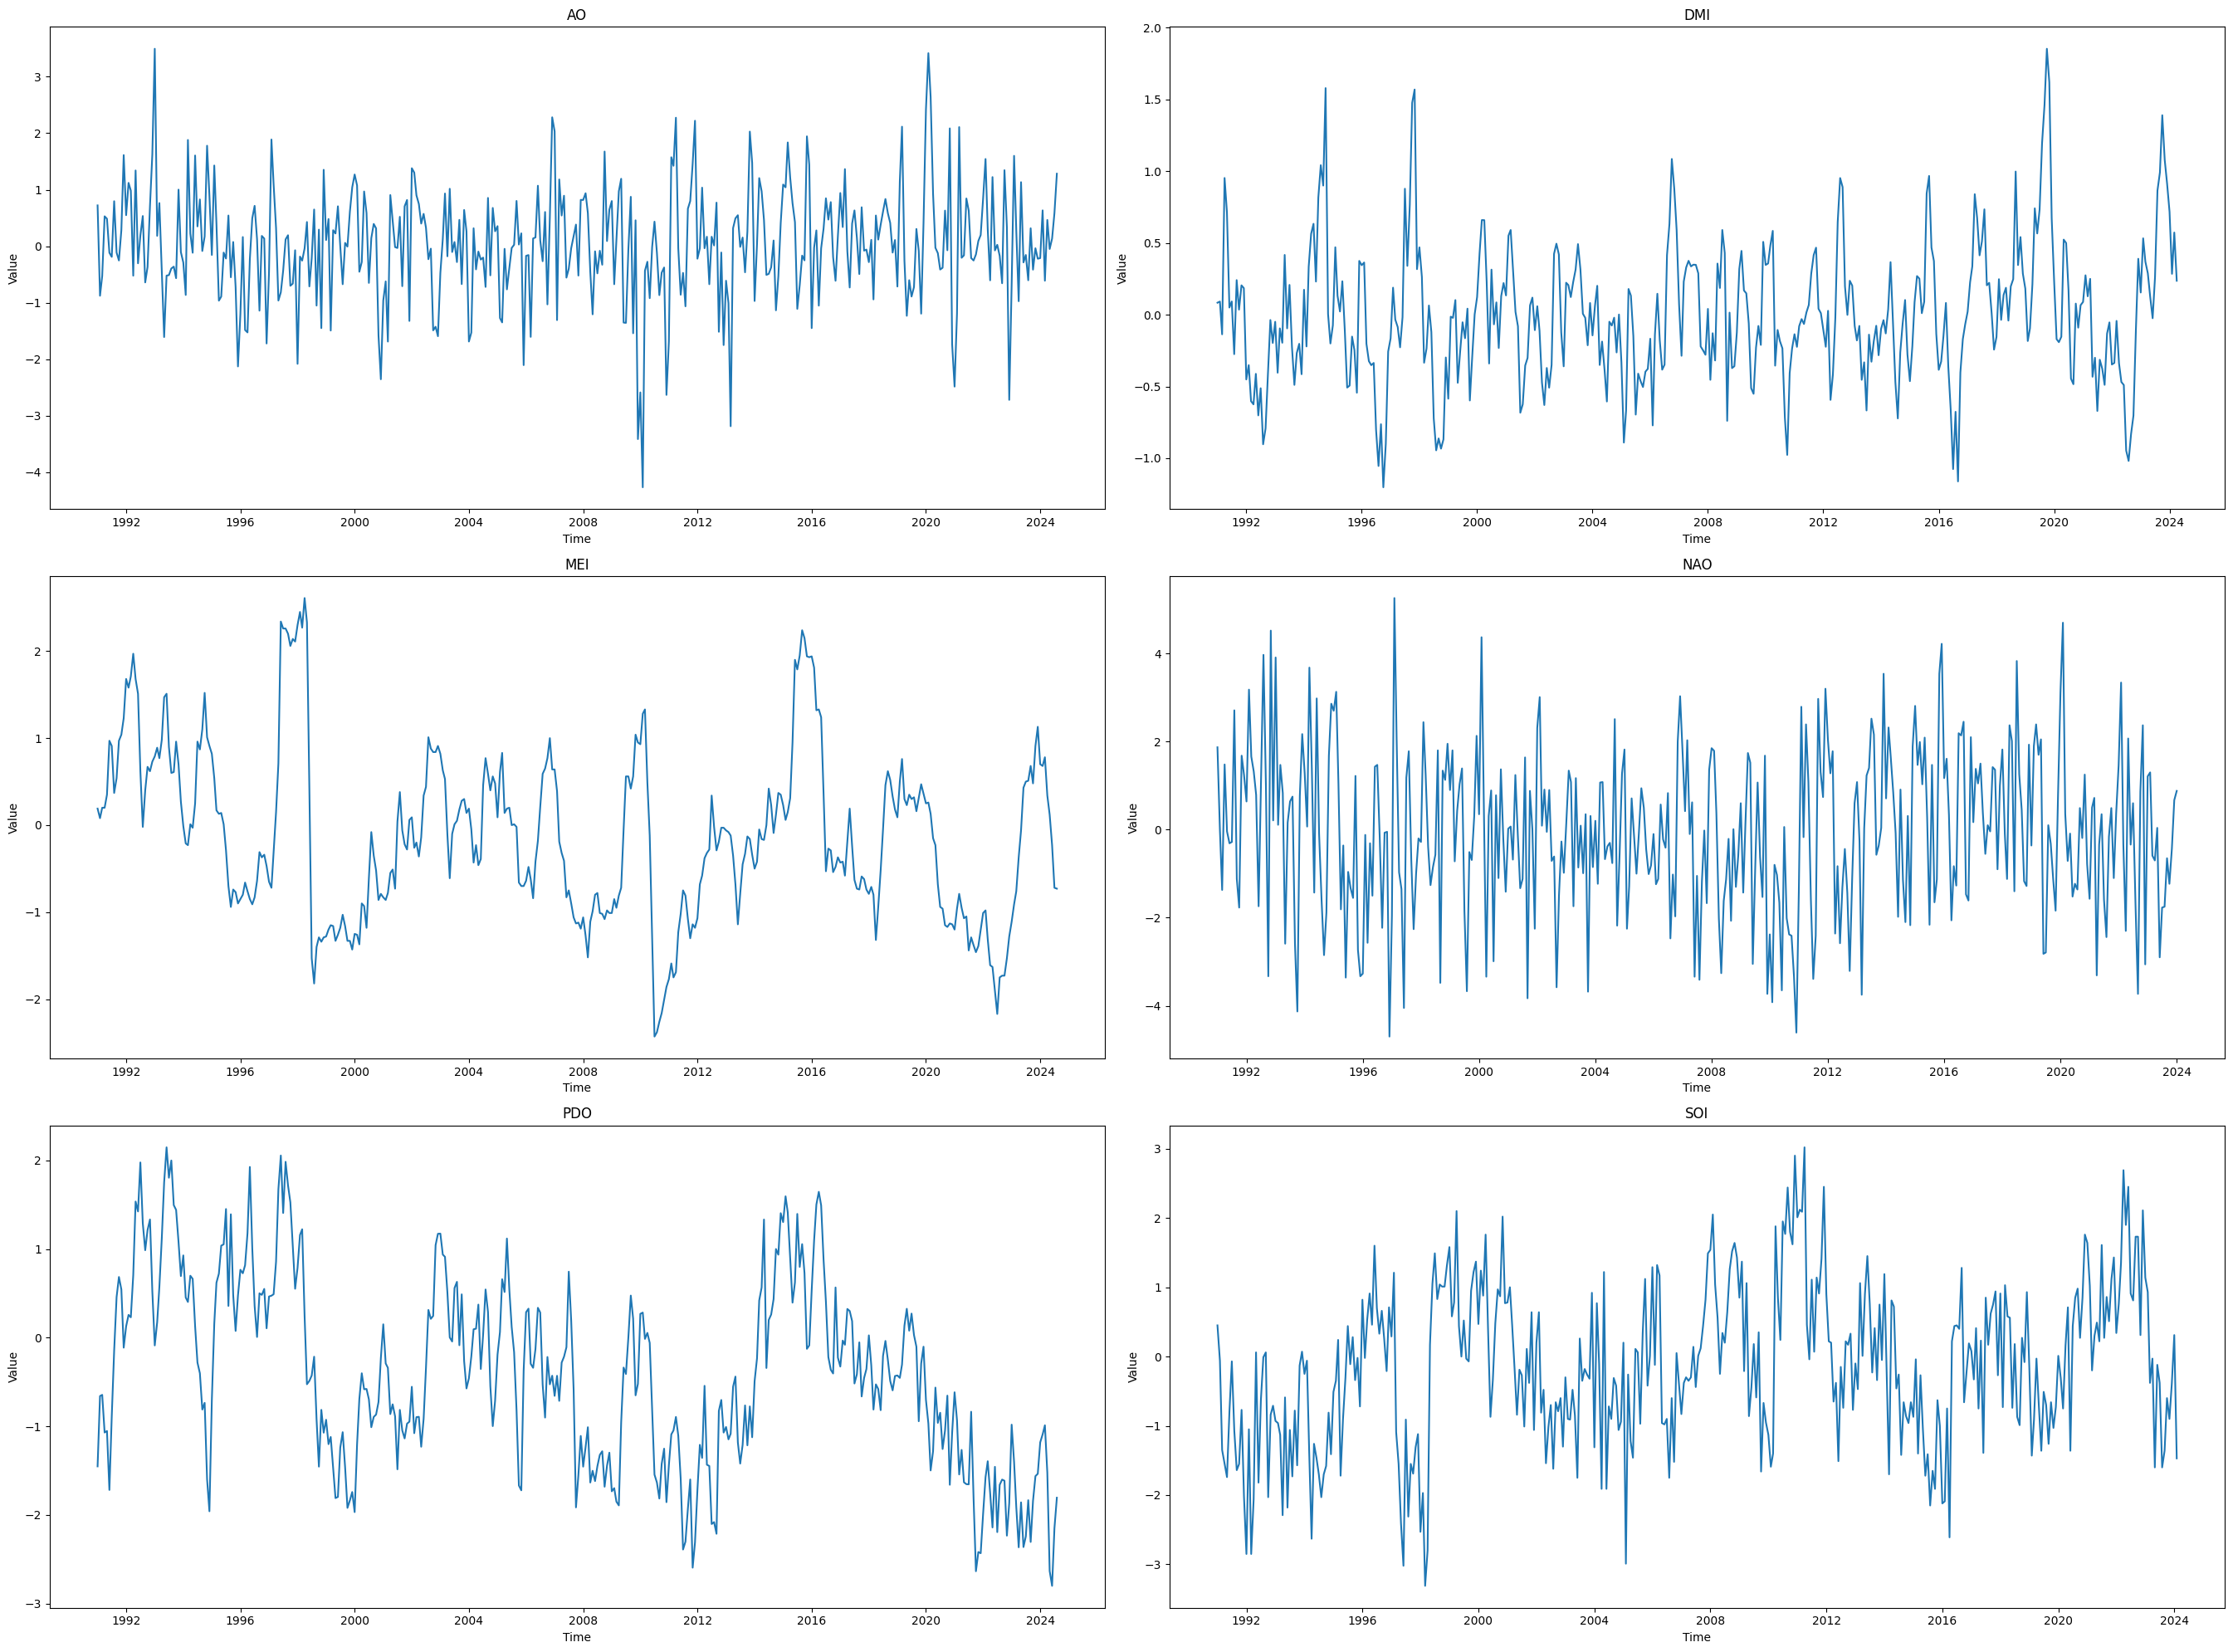

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(27, 20))
variables = [
    (ao.copy(), 'AO'),
    (dmi.copy(), 'DMI'),
    (mei.copy(), 'MEI'),
    (nao.copy(), 'NAO'),
    (pdo.copy(), 'PDO'),
    (soi.copy(), 'SOI')
]

for ax, (var, title) in zip(axs.flatten(), variables):
    var.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()


In [26]:
long_time = pd.date_range(start='1991-01-01', end='2025-04-01', freq='MS')

data_dict = {
    'Time': long_time.values,
    'D20' : d20.reindex(time=long_time, fill_value=np.nan).values,
    'Windspeed': ws_avg.reindex(time=long_time, fill_value=np.nan).values,
    'U10': u10_avg.reindex(time=long_time, fill_value=np.nan).values,
    'V10': v10_avg.reindex(time=long_time, fill_value=np.nan).values,
    'U_current': u_current.reindex(time=long_time, fill_value=np.nan).values,
    'V_current': v_current.reindex(time=long_time, fill_value=np.nan).values,
    'SST': sst_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Precip_Rate': prep_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Latent_Heatflux': latent_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Longwave_Rad': lwrad_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Shortwave_Rad': swrad_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Sensible_Heatflux': sensible_avg.reindex(time=long_time, fill_value=np.nan).values,
    'Total_Heatflux': totalhf_avg.reindex(time=long_time, fill_value=np.nan).values,

    'AO': ao.reindex(time=long_time, fill_value=np.nan).values,
    'DMI': dmi.reindex(time=long_time, fill_value=np.nan).values,
    'MEI': mei.reindex(time=long_time, fill_value=np.nan).values,
    'NAO': nao.reindex(time=long_time, fill_value=np.nan).values,
    'PDO': pdo.reindex(time=long_time, fill_value=np.nan).values,
    'SOI': soi.reindex(time=long_time, fill_value=np.nan).values
}

df = pd.DataFrame(data_dict)

df['Year'] = pd.to_datetime(df['Time']).dt.year
df['Month'] = pd.to_datetime(df['Time']).dt.month

In [27]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
df

Time        D20  Windspeed       U10       V10  U_current  \
0   1991-01-01  54.960640   5.084927  0.454114  0.366376   0.802472   
1   1991-02-01  59.899442   4.630802  1.572911 -1.119077  -1.843393   
2   1991-03-01  70.225124   4.426265 -2.789140  0.800078  -0.307724   
3   1991-04-01  67.375125   4.365088 -2.719442  1.171713   0.924412   
4   1991-05-01  63.783066   6.266210 -5.034388  3.068174   3.259027   
..         ...        ...        ...       ...       ...        ...   
407 2024-12-01        NaN        NaN       NaN       NaN        NaN   
408 2025-01-01        NaN        NaN       NaN       NaN        NaN   
409 2025-02-01        NaN        NaN       NaN       NaN        NaN   
410 2025-03-01        NaN        NaN       NaN       NaN        NaN   
411 2025-04-01        NaN        NaN       NaN       NaN        NaN   

     V_current        SST  Precip_Rate  Latent_Heatflux  ...  \
0    -7.858713  28.514919     7.720513      -110.861671  ...   
1    -2.688460  28.686356     8.397621      -106.690338  ...   
2    -4.911318  29.185633     4.312831      -111.479942  ...   
3    -5.561043  29.489611     4.240137      -122.542458  ...   
4    -2.550943  28.738018     4.254697      -143.516434  ...   
..         ...        ...          ...              ...  ...   
407        NaN        NaN          NaN              NaN  ...   
408        NaN        NaN          NaN              NaN  ...   
409        NaN        NaN          NaN              NaN  ...   
410        NaN        NaN          NaN              NaN  ...   
411        NaN        NaN          NaN              NaN  ...   

     Sensible_Heatflux  Total_Heatflux     AO       DMI   MEI   NAO       PDO  \
0           -12.759721       70.243980  0.723  0.083455  0.19  1.87 -1.452161   
1           -11.764043       71.799942 -0.876  0.091428  0.08 -0.02 -0.659165   
2           -10.905128       76.691292 -0.527 -0.136740  0.20 -1.37 -0.645614   
3           -12.666158       39.955452  0.530  0.952401  0.20  1.48 -1.070165   
4           -13.098854       -9.288574  0.486  0.714247  0.35 -0.04 -1.052908   
..                 ...             ...    ...       ...   ...   ...       ...   
407                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
408                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
409                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
410                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
411                NaN             NaN    NaN       NaN   NaN   NaN       NaN   

      SOI  Year  Month  
0    0.45  1991      1  
1   -0.06  1991      2  
2   -1.35  1991      3  
3   -1.55  1991      4  
4   -1.74  1991      5  
..    ...   ...    ...  
407   NaN  2024     12  
408   NaN  2025      1  
409   NaN  2025      2  
410   NaN  2025      3  
411   NaN  2025      4  

[412 rows x 22 columns]

### variable selection


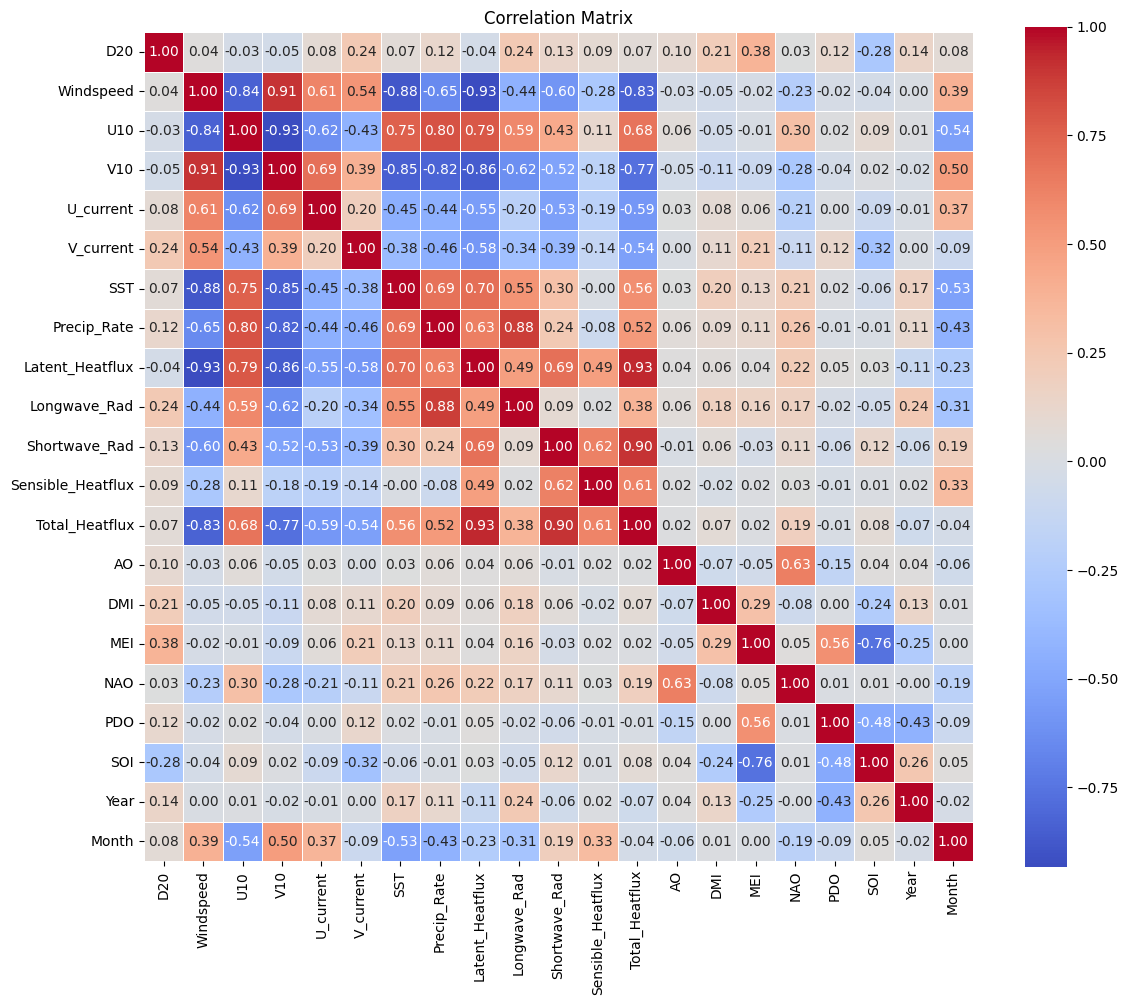

In [28]:
correlation_matrix = df.drop('Time', axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


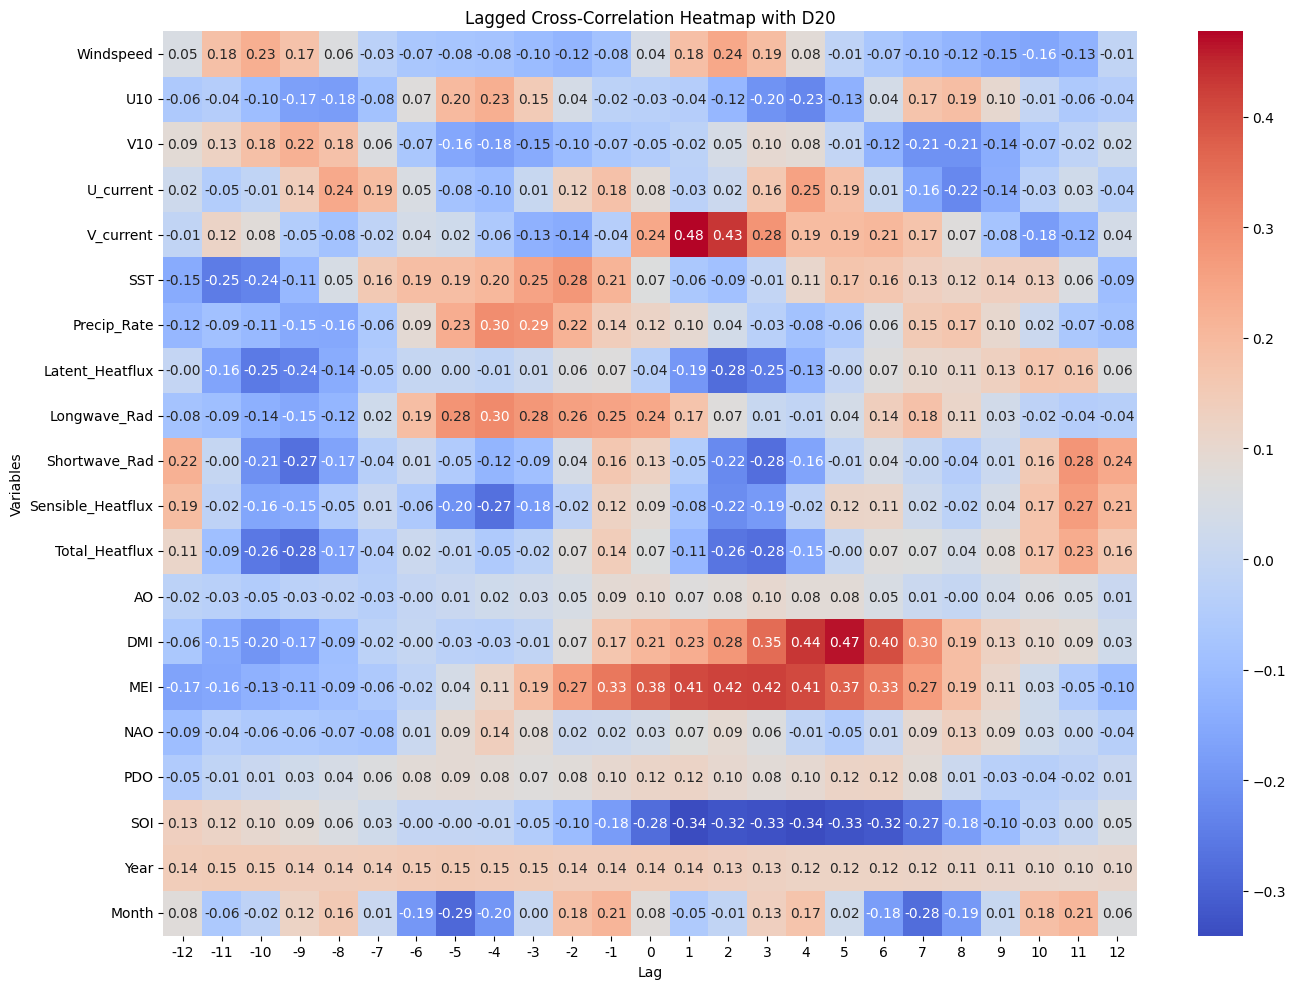

In [29]:
def calculate_cross_correlation(df, main_var, max_lag=12):
    lags = range(-max_lag, max_lag + 1)
    variables = df.columns.drop(main_var)
    cross_corr = pd.DataFrame(index=variables, columns=lags)

    for var in variables:
        for lag in lags:
            if lag < 0:
                cross_corr.loc[var, lag] = df[main_var].shift(-lag).corr(df[var])
            else:
                cross_corr.loc[var, lag] = df[main_var].corr(df[var].shift(lag))

    return cross_corr.astype(float)

cross_corr_matrix = calculate_cross_correlation(df.drop('Time', axis=1), main_var='D20', max_lag=12)

plt.figure(figsize=(14, 10))
sns.heatmap(cross_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title('Lagged Cross-Correlation Heatmap with D20')
plt.xlabel('Lag')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

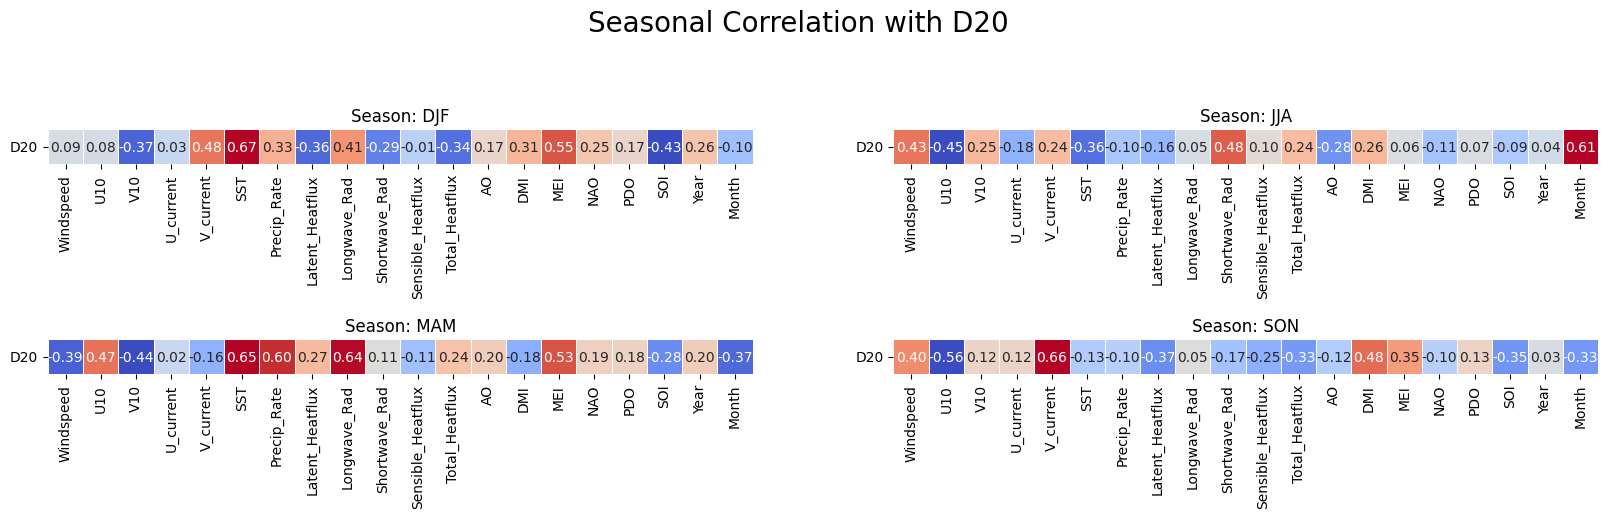

In [30]:
df['Season'] = df['Month'].map({
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'
})

numeric_columns = df.select_dtypes(include=[np.number]).columns
grouped = df.groupby('Season')[numeric_columns]

fig, axes = plt.subplots(2, 2, figsize=(20, 5))
fig.suptitle('Seasonal Correlation with D20', fontsize=20)

for (season, group), ax in zip(grouped, axes.flatten()):
    correlation_matrix = group.corr()[['D20']]
    correlation_matrix = correlation_matrix.drop('D20')

    sns.heatmap(correlation_matrix.T, annot=True, cmap='coolwarm', fmt=".2f",
                cbar=False, square=True, linewidths=0.5, ax=ax)

    ax.set_title(f'Season: {season}')
    ax.set_xticklabels(correlation_matrix.index, rotation=90)
    ax.set_yticklabels(['D20'], rotation=0)

df = df.drop('Season', axis=1)

In [31]:
df

Time        D20  Windspeed       U10       V10  U_current  \
0   1991-01-01  54.960640   5.084927  0.454114  0.366376   0.802472   
1   1991-02-01  59.899442   4.630802  1.572911 -1.119077  -1.843393   
2   1991-03-01  70.225124   4.426265 -2.789140  0.800078  -0.307724   
3   1991-04-01  67.375125   4.365088 -2.719442  1.171713   0.924412   
4   1991-05-01  63.783066   6.266210 -5.034388  3.068174   3.259027   
..         ...        ...        ...       ...       ...        ...   
407 2024-12-01        NaN        NaN       NaN       NaN        NaN   
408 2025-01-01        NaN        NaN       NaN       NaN        NaN   
409 2025-02-01        NaN        NaN       NaN       NaN        NaN   
410 2025-03-01        NaN        NaN       NaN       NaN        NaN   
411 2025-04-01        NaN        NaN       NaN       NaN        NaN   

     V_current        SST  Precip_Rate  Latent_Heatflux  ...  \
0    -7.858713  28.514919     7.720513      -110.861671  ...   
1    -2.688460  28.686356     8.397621      -106.690338  ...   
2    -4.911318  29.185633     4.312831      -111.479942  ...   
3    -5.561043  29.489611     4.240137      -122.542458  ...   
4    -2.550943  28.738018     4.254697      -143.516434  ...   
..         ...        ...          ...              ...  ...   
407        NaN        NaN          NaN              NaN  ...   
408        NaN        NaN          NaN              NaN  ...   
409        NaN        NaN          NaN              NaN  ...   
410        NaN        NaN          NaN              NaN  ...   
411        NaN        NaN          NaN              NaN  ...   

     Sensible_Heatflux  Total_Heatflux     AO       DMI   MEI   NAO       PDO  \
0           -12.759721       70.243980  0.723  0.083455  0.19  1.87 -1.452161   
1           -11.764043       71.799942 -0.876  0.091428  0.08 -0.02 -0.659165   
2           -10.905128       76.691292 -0.527 -0.136740  0.20 -1.37 -0.645614   
3           -12.666158       39.955452  0.530  0.952401  0.20  1.48 -1.070165   
4           -13.098854       -9.288574  0.486  0.714247  0.35 -0.04 -1.052908   
..                 ...             ...    ...       ...   ...   ...       ...   
407                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
408                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
409                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
410                NaN             NaN    NaN       NaN   NaN   NaN       NaN   
411                NaN             NaN    NaN       NaN   NaN   NaN       NaN   

      SOI  Year  Month  
0    0.45  1991      1  
1   -0.06  1991      2  
2   -1.35  1991      3  
3   -1.55  1991      4  
4   -1.74  1991      5  
..    ...   ...    ...  
407   NaN  2024     12  
408   NaN  2025      1  
409   NaN  2025      2  
410   NaN  2025      3  
411   NaN  2025      4  

[412 rows x 22 columns]

In [32]:
selected_columns = [
    'Time', 'D20', 'Windspeed', 'V_current', 'SST', 'Precip_Rate',
    'Longwave_Rad', 'Shortwave_Rad', 'Total_Heatflux', 'DMI', 'MEI', 'SOI']

df_copy = df[selected_columns]

In [33]:
selected_columns = [
    'D20', 'Windspeed', 'V_current', 'SST', 'Precip_Rate',
    'Longwave_Rad', 'Shortwave_Rad', 'Total_Heatflux', 'DMI', 'MEI', 'SOI']

df = df[selected_columns]

df

D20  Windspeed  V_current        SST  Precip_Rate  Longwave_Rad  \
0    54.960640   5.084927  -7.858713  28.514919     7.720513    -48.089699   
1    59.899442   4.630802  -2.688460  28.686356     8.397621    -47.762600   
2    70.225124   4.426265  -4.911318  29.185633     4.312831    -53.492870   
3    67.375125   4.365088  -5.561043  29.489611     4.240137    -54.914364   
4    63.783066   6.266210  -2.550943  28.738018     4.254697    -53.080555   
..         ...        ...        ...        ...          ...           ...   
407        NaN        NaN        NaN        NaN          NaN           NaN   
408        NaN        NaN        NaN        NaN          NaN           NaN   
409        NaN        NaN        NaN        NaN          NaN           NaN   
410        NaN        NaN        NaN        NaN          NaN           NaN   
411        NaN        NaN        NaN        NaN          NaN           NaN   

     Shortwave_Rad  Total_Heatflux       DMI   MEI   SOI  
0       241.955093       70.243980  0.083455  0.19  0.45  
1       238.016907       71.799942  0.091428  0.08 -0.06  
2       252.569244       76.691292 -0.136740  0.20 -1.35  
3       230.078415       39.955452  0.952401  0.20 -1.55  
4       200.407257       -9.288574  0.714247  0.35 -1.74  
..             ...             ...       ...   ...   ...  
407            NaN             NaN       NaN   NaN   NaN  
408            NaN             NaN       NaN   NaN   NaN  
409            NaN             NaN       NaN   NaN   NaN  
410            NaN             NaN       NaN   NaN   NaN  
411            NaN             NaN       NaN   NaN   NaN  

[412 rows x 11 columns]

# SARIMA (future x prediction)


In [34]:
# This script performs the following steps:
# 1. Scaling: Standardizes the data while excluding NaN values.
# 2. SARIMA: Fills missing values using the SARIMA model.
# 3. Inverse Scaling: Restores the data to its original scale.

scalers = {}

def standard_scaling_with_nan(df):
    scaled_df = df.copy()

    for col in df.columns:
        non_nan_mask = df[col].notna()
        data_to_scale = df.loc[non_nan_mask, col].values.reshape(-1, 1)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_to_scale).flatten()

        scalers[col] = scaler

        scaled_df.loc[non_nan_mask, col] = scaled_data

    return scaled_df

scaled_df = standard_scaling_with_nan(df)

def fill_missing_sarima(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    filled_series = series.fillna(0)

    model = SARIMAX(filled_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    forecast = model_fit.predict(start=0, end=len(series)-1, dynamic=False)

    series_filled = series.copy()
    series_filled[np.isnan(series)] = forecast[np.isnan(series)].astype(series.dtype)

    return series_filled

columns_to_fill = scaled_df.columns.difference(['D20'])
for col in columns_to_fill:
    print(f"Filling missing values in column: {col}")
    scaled_df.loc[:, col] = fill_missing_sarima(scaled_df[col])

def inverse_scaling_with_nan(scaled_df, scalers):
    original_df = scaled_df.copy()

    for col in scaled_df.columns:
        scaler = scalers.get(col)

        if scaler is not None:
            non_nan_mask = scaled_df[col].notna()
            data_to_inverse = scaled_df.loc[non_nan_mask, col].values.reshape(-1, 1)
            inverse_data = scaler.inverse_transform(data_to_inverse).flatten()

            original_df.loc[non_nan_mask, col] = inverse_data

    return original_df

df = inverse_scaling_with_nan(scaled_df, scalers)


df

Filling missing values in column: DMI
Filling missing values in column: Longwave_Rad
Filling missing values in column: MEI
Filling missing values in column: Precip_Rate
Filling missing values in column: SOI
Filling missing values in column: SST
Filling missing values in column: Shortwave_Rad
Filling missing values in column: Total_Heatflux
Filling missing values in column: V_current
Filling missing values in column: Windspeed


D20  Windspeed  V_current        SST  Precip_Rate  Longwave_Rad  \
0    54.960640   5.084927  -7.858713  28.514919     7.720513    -48.089699   
1    59.899442   4.630802  -2.688460  28.686356     8.397621    -47.762600   
2    70.225124   4.426265  -4.911318  29.185633     4.312831    -53.492870   
3    67.375125   4.365088  -5.561043  29.489611     4.240137    -54.914364   
4    63.783066   6.266210  -2.550943  28.738018     4.254697    -53.080555   
..         ...        ...        ...        ...          ...           ...   
407        NaN   5.155397  -7.457410  28.489817     6.812762    -50.082241   
408        NaN   5.273018  -4.766273  28.227280     8.589540    -48.176594   
409        NaN   5.304718  -4.412459  28.079721     7.627302    -48.638161   
410        NaN   5.010940  -5.674114  28.295944     5.607151    -50.700901   
411        NaN   5.848127  -5.670831  27.951649     4.941857    -51.425312   

     Shortwave_Rad  Total_Heatflux       DMI       MEI       SOI  
0       241.955093       70.243980  0.083455  0.190000  0.450000  
1       238.016907       71.799934  0.091428  0.080000 -0.060000  
2       252.569244       76.691292 -0.136740  0.200000 -1.350000  
3       230.078415       39.955452  0.952401  0.200000 -1.550000  
4       200.407257       -9.288575  0.714247  0.350000 -1.740000  
..             ...             ...       ...       ...       ...  
407     236.661301       52.187531  0.038772 -0.026632  0.142860  
408     225.715820       36.847500 -0.010851 -0.214543 -0.116491  
409     229.520432       39.085281  0.048272 -0.016894 -0.342866  
410     229.900604       36.223724  0.085594 -0.219290 -0.405772  
411     214.370056        4.003239  0.069444 -0.134982 -0.116949  

[412 rows x 11 columns]

In [35]:
df_copy

Time        D20  Windspeed  V_current        SST  Precip_Rate  \
0   1991-01-01  54.960640   5.084927  -7.858713  28.514919     7.720513   
1   1991-02-01  59.899442   4.630802  -2.688460  28.686356     8.397621   
2   1991-03-01  70.225124   4.426265  -4.911318  29.185633     4.312831   
3   1991-04-01  67.375125   4.365088  -5.561043  29.489611     4.240137   
4   1991-05-01  63.783066   6.266210  -2.550943  28.738018     4.254697   
..         ...        ...        ...        ...        ...          ...   
407 2024-12-01        NaN        NaN        NaN        NaN          NaN   
408 2025-01-01        NaN        NaN        NaN        NaN          NaN   
409 2025-02-01        NaN        NaN        NaN        NaN          NaN   
410 2025-03-01        NaN        NaN        NaN        NaN          NaN   
411 2025-04-01        NaN        NaN        NaN        NaN          NaN   

     Longwave_Rad  Shortwave_Rad  Total_Heatflux       DMI   MEI   SOI  
0      -48.089699     241.955093       70.243980  0.083455  0.19  0.45  
1      -47.762600     238.016907       71.799942  0.091428  0.08 -0.06  
2      -53.492870     252.569244       76.691292 -0.136740  0.20 -1.35  
3      -54.914364     230.078415       39.955452  0.952401  0.20 -1.55  
4      -53.080555     200.407257       -9.288574  0.714247  0.35 -1.74  
..            ...            ...             ...       ...   ...   ...  
407           NaN            NaN             NaN       NaN   NaN   NaN  
408           NaN            NaN             NaN       NaN   NaN   NaN  
409           NaN            NaN             NaN       NaN   NaN   NaN  
410           NaN            NaN             NaN       NaN   NaN   NaN  
411           NaN            NaN             NaN       NaN   NaN   NaN  

[412 rows x 12 columns]

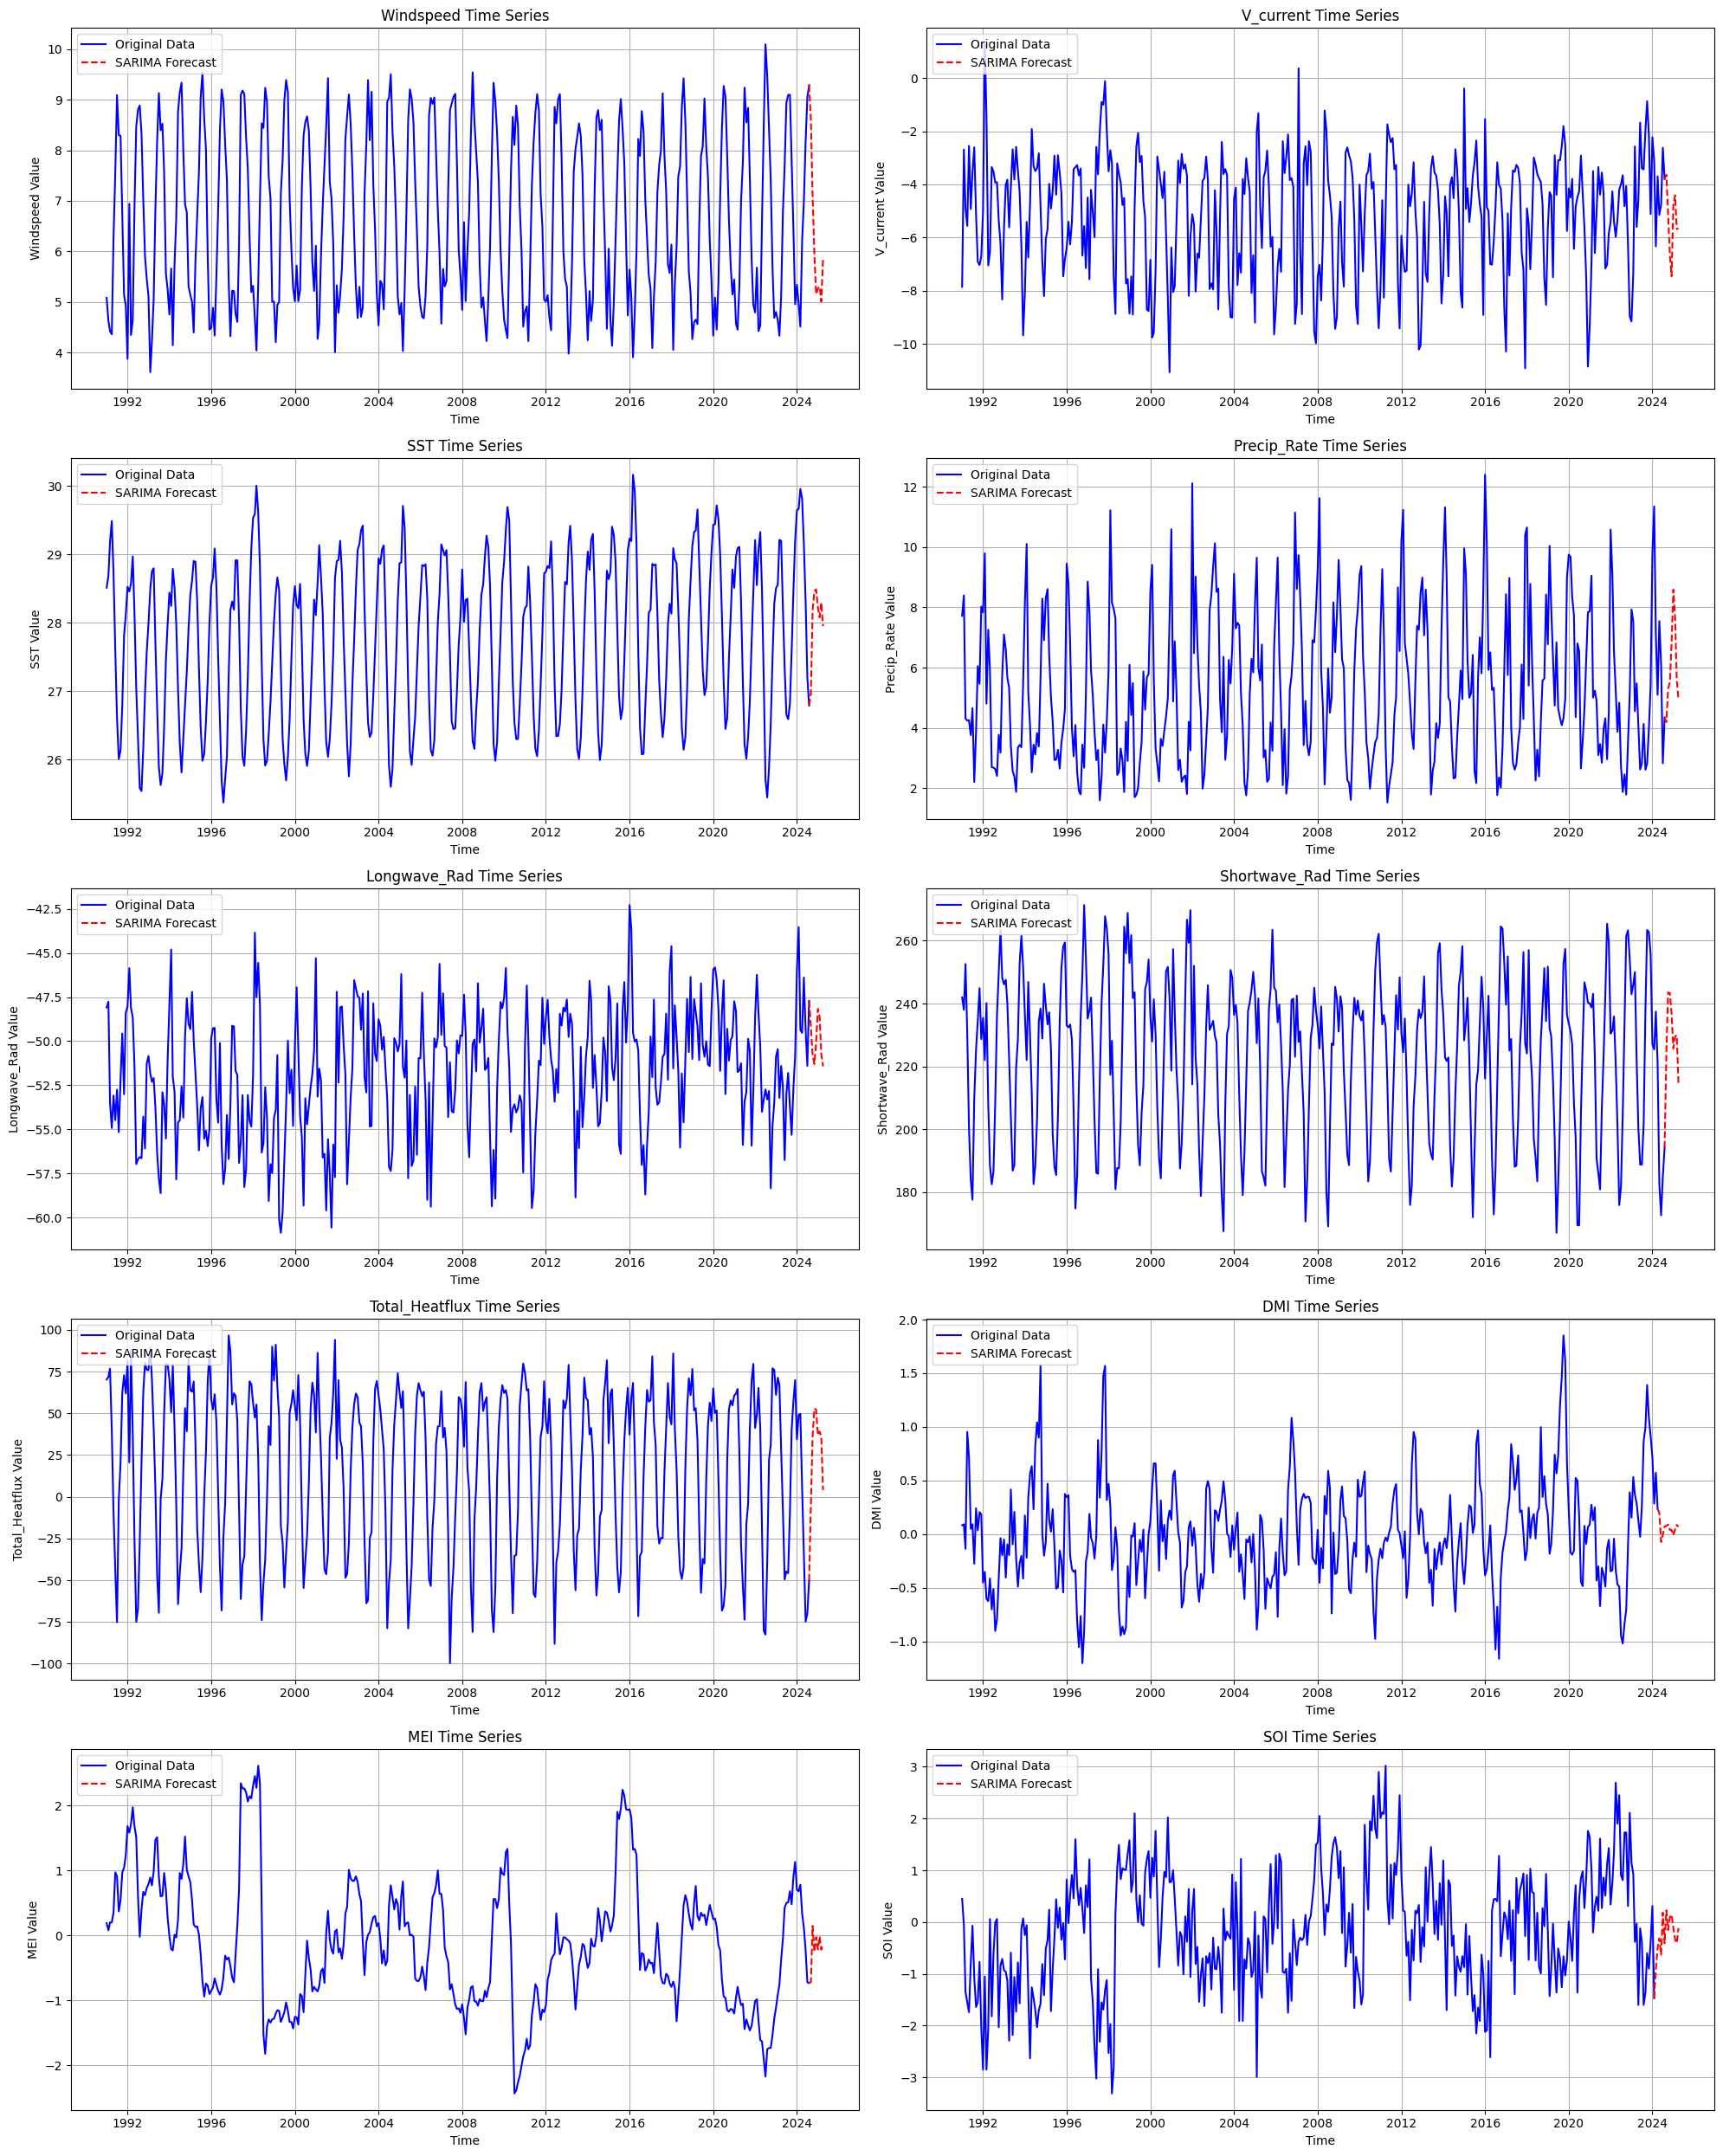

In [36]:
# This code visualizes the observed and SARIMA-forecasted values for each X variable.
# It shows the original data in blue and the SARIMA forecast in red dashed lines

forecast_periods = {
    'SOI': 14,
    'DMI': 12,
    # default period is 8
}

columns_to_plot = [col for col in df.columns if col != 'D20']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    ax = axes[i]

    periods = forecast_periods.get(col, 8)

    fc_start_time = df_copy['Time'].iloc[-periods]
    forecast_time = pd.date_range(start=fc_start_time, periods=periods, freq='MS')
    new_time = df_copy['Time']

    ax.plot(new_time[:-periods], df_copy[col].dropna(), label='Original Data', color='blue')

    ax.plot(new_time[-periods-1:], df[col].iloc[-periods-1:], label='SARIMA Forecast', color='red', linestyle='--')

    ax.set_title(f'{col} Time Series')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{col} Value')
    ax.legend(loc='upper left')
    ax.grid()

plt.tight_layout()
plt.show()

# Data preprocessing

In [37]:
forecast = df.loc[400:412].copy() # 2024.05 ~
df = df.drop(index=range(400, 412)) # ~ 2024.04

In [38]:
df

D20  Windspeed  V_current        SST  Precip_Rate  Longwave_Rad  \
0     54.960640   5.084927  -7.858713  28.514919     7.720513    -48.089699   
1     59.899442   4.630802  -2.688460  28.686356     8.397621    -47.762600   
2     70.225124   4.426265  -4.911318  29.185633     4.312831    -53.492870   
3     67.375125   4.365088  -5.561043  29.489611     4.240137    -54.914364   
4     63.783066   6.266210  -2.550943  28.738018     4.254697    -53.080555   
..          ...        ...        ...        ...          ...           ...   
395  124.376897   4.958195  -5.117179  29.198469     5.411335    -50.839001   
396  117.300079   5.341755  -2.225760  29.646479     9.790506    -45.946705   
397  121.968669   4.951991  -3.115872  29.670380    11.354394    -43.540283   
398  118.355688   4.517852  -6.332487  29.958645     7.095022    -49.374813   
399  108.767079   6.211578  -3.697310  29.816385     5.096010    -49.527142   

     Shortwave_Rad  Total_Heatflux       DMI   MEI       SOI  
0       241.955093       70.243980  0.083455  0.19  0.450000  
1       238.016907       71.799934  0.091428  0.08 -0.060000  
2       252.569244       76.691292 -0.136740  0.20 -1.350000  
3       230.078415       39.955452  0.952401  0.20 -1.550000  
4       200.407257       -9.288575  0.714247  0.35 -1.740000  
..             ...             ...       ...   ...       ...  
395     255.561752       69.883904  0.912371  1.13 -0.390000  
396     227.076447       34.431362  0.716561  0.70  0.310000  
397     225.391861       48.958542  0.284619  0.68 -1.470000  
398     237.443253       49.651733  0.572323  0.78 -0.913393  
399     220.956604        5.198738  0.236245  0.34 -0.506729  

[400 rows x 11 columns]

# Feature engineering

In [39]:
X = df.drop(columns=["D20"])
y = df["D20"]

In [40]:
n = len(df)

train_size = int(n * 0.9)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Eigenvalues: [4.33149121 2.09915767 1.24818893 0.88563248 0.5952209  0.4863906
 0.23605759 0.08691341 0.05338235 0.00542002]
Number of eigenvalues: 10


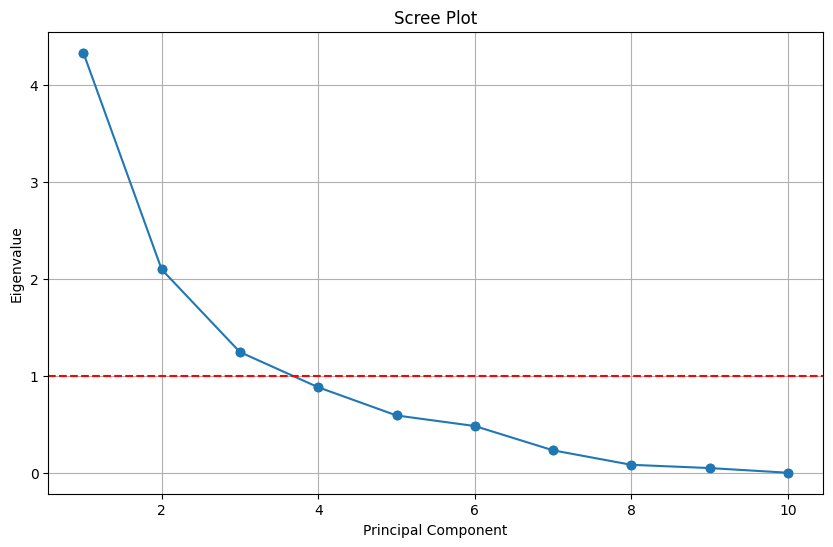

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=X_train_scaled.shape[1])
pca.fit(X_train_scaled)

ev = pca.explained_variance_

print('Eigenvalues:', ev)
print('Number of eigenvalues:', len(ev))

# Scree Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev) + 1), ev)
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
plt.grid()
plt.show()

In [42]:
# Select 3 principal components based on the Kaiser rule (Eigenvalues > 1)
pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca  = pca.transform(X_train_scaled)
principalDf = pd.DataFrame(data = X_train_pca, columns = ['PC1', 'PC2', 'PC3'])

In [43]:
# Display the contribution of each X variable to the principal components (Eigenvectors)
eigenvectors = pca.components_
principal_components_df = pd.DataFrame(eigenvectors, columns=X_train.columns)
principal_components_df.index = [f'PC{i+1}' for i in range(eigenvectors.shape[0])]

principal_components_df

Windspeed  V_current       SST  Precip_Rate  Longwave_Rad  Shortwave_Rad  \
PC1   0.443074   0.322479 -0.395705    -0.394169     -0.330671      -0.311694   
PC2   0.011095   0.251917  0.142142     0.140704      0.218007      -0.179347   
PC3  -0.124080   0.092470 -0.113517    -0.386195     -0.471859       0.575238   

     Total_Heatflux       DMI       MEI       SOI  
PC1       -0.421586 -0.042034 -0.012557 -0.039832  
PC2       -0.093554  0.326894  0.594147 -0.589998  
PC3        0.371288 -0.010223  0.235025 -0.259374

In [44]:
principalDf

PC1       PC2       PC3
0   -2.542112 -0.215081 -0.197232
1   -2.062089  0.672649 -0.107166
2   -1.588080  0.376204  1.883365
3   -1.131094  1.348390  1.232575
4    0.736482  2.064376  0.038057
..        ...       ...       ...
355  2.812860 -1.253473 -0.847724
356  0.792622 -1.651566 -0.419427
357 -0.561646 -1.197835  0.448065
358 -1.672718 -1.559800 -0.171440
359 -2.780177 -2.096584 -0.941667

[360 rows x 3 columns]

In [45]:
# Apply the scaling and PCA learned from the train data to the test data
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
principalDf_test = pd.DataFrame(data=X_test_pca, columns=['PC1', 'PC2', 'PC3'])

principalDf_test

PC1       PC2       PC3
0  -2.628300 -1.801585 -1.094091
1  -2.805942 -0.843400 -0.910763
2  -1.440874 -0.271827  0.772622
3  -1.134281 -0.643712 -0.403582
4   0.792242 -0.854944 -1.642362
5   2.628788 -0.859184 -0.859490
6   3.136052 -2.058964 -1.996537
7   2.363687 -1.258332 -0.461590
8   1.417768 -1.614109 -0.794863
9  -0.150035 -2.068694  0.049287
10 -0.736722 -2.621536  1.655502
11 -1.640245 -2.088888  0.952226
12 -2.447457 -0.570882 -1.281307
13 -1.903150 -0.673693 -1.321623
14 -2.213258 -1.399740 -0.632878
15 -1.573831 -2.557310 -1.163549
16  0.743069 -2.303126 -1.266143
17  2.492193 -2.392606 -2.736050
18  3.773383 -2.336355 -2.036124
19  3.248540 -2.415123 -0.711319
20  1.548437 -3.112601  0.077016
21  1.349697 -3.464182  1.675424
22 -0.801053 -2.108006  1.643189
23 -2.078805 -2.526718  0.516678
24 -2.518521 -1.632256 -0.422832
25 -2.455511 -0.968228 -0.088927
26 -1.297472 -0.044967  1.300580
27 -1.131354  0.072548 -0.229206
28  0.772852  1.055971 -0.174653
29  2.838472  0.533751 -0.084613
30  2.712602  0.874766 -0.599424
31  2.287940  1.986727 -0.407529
32  2.033501  1.699682  1.254704
33  0.857195  1.289501  2.265184
34 -0.539859  1.652628  1.986091
35 -2.020753  1.375990  1.310967
36 -2.130252  1.817380 -1.193883
37 -2.848971  2.562250 -1.278141
38 -2.510485  1.511941  0.215250
39 -0.671813  1.167840 -0.391247

In [46]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize XGBRegressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=2024)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_grid,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=2024, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(principalDf, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Test set predictions
y_test_pred = best_model.predict(principalDf_test)

# Evaluation (Mean Squared Error)
test_mse = mean_squared_error(y_test, y_test_pred)

# Root Mean Squared Error
test_rmse = np.sqrt(test_mse)

# Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Test MSE: 218.22127639598858
Test RMSE: 14.772314524000246
Test MAE: 11.041557785130907


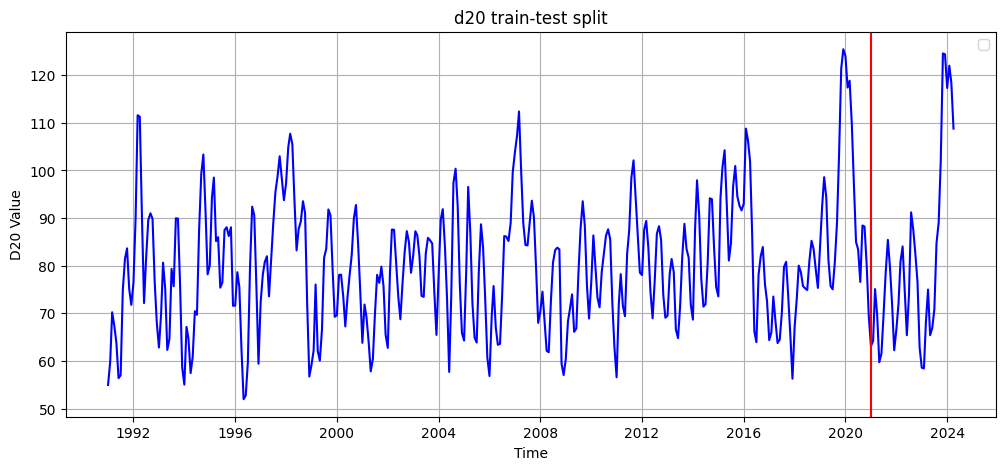

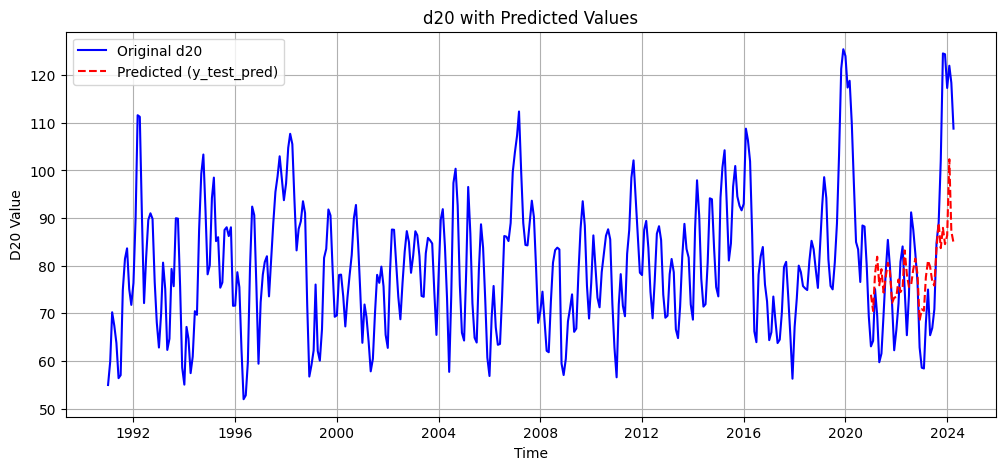

In [47]:
# Create the test time coordinates for y_test_pred
test_time_pred = d20.time[-40:]  # Last 40 months for y_test_pred

# train-test graph
plt.figure(figsize=(12, 5))
plt.plot(d20.time, d20, color='blue')

plt.axvline(x=d20.time[-40].values, color='red')

plt.title('d20 train-test split')
plt.xlabel('Time')
plt.ylabel('D20 Value')
plt.legend()
plt.grid()
plt.show()

# Visualization of d20 with y_test_pred
plt.figure(figsize=(12, 5))

# Plot original d20 data
plt.plot(d20.time, d20, label='Original d20', color='blue')

# Plot y_test_pred with red dashed line
plt.plot(test_time_pred, y_test_pred, 'r--', label='Predicted (y_test_pred)')

# Add labels, title, and legend
plt.title('d20 with Predicted Values')
plt.xlabel('Time')
plt.ylabel('D20 Value')
plt.legend()
plt.grid()
plt.show()

# forecast

In [48]:
forecast

D20  Windspeed  V_current        SST  Precip_Rate  Longwave_Rad  \
400  NaN   6.982633  -5.145585  29.159401     7.543987    -46.395138   
401  NaN   8.177649  -4.770730  28.315985     6.099922    -49.356548   
402  NaN   9.043585  -2.619782  27.201447     2.821316    -51.395851   
403  NaN   9.284401  -3.794817  26.790129     4.346815    -47.714695   
404  NaN   8.603709  -3.634907  26.966990     4.190558    -49.172234   
405  NaN   7.099785  -5.093409  28.186396     5.302655    -50.798397   
406  NaN   5.936450  -6.659778  28.461910     5.508757    -51.293430   
407  NaN   5.155397  -7.457410  28.489817     6.812762    -50.082241   
408  NaN   5.273018  -4.766273  28.227280     8.589540    -48.176594   
409  NaN   5.304718  -4.412459  28.079721     7.627302    -48.638161   
410  NaN   5.010940  -5.674114  28.295944     5.607151    -50.700901   
411  NaN   5.848127  -5.670831  27.951649     4.941857    -51.425312   

     Shortwave_Rad  Total_Heatflux       DMI       MEI       SOI  
400     182.547729      -33.151089  0.196113  0.120000 -0.313392  
401     172.621155      -74.747871 -0.072937 -0.230000 -0.629450  
402     184.940765      -70.037323 -0.007207 -0.720000  0.182527  
403     194.154404      -50.253738  0.071570 -0.730000 -0.411026  
404     224.380981       -4.305709  0.075921 -0.717669  0.226785  
405     243.545227       36.016434  0.089427  0.147277 -0.152785  
406     243.311844       52.718594  0.039267 -0.250708  0.097711  
407     236.661301       52.187531  0.038772 -0.026632  0.142860  
408     225.715820       36.847500 -0.010851 -0.214543 -0.116491  
409     229.520432       39.085281  0.048272 -0.016894 -0.342866  
410     229.900604       36.223724  0.085594 -0.219290 -0.405772  
411     214.370056        4.003239  0.069444 -0.134982 -0.116949

In [49]:
# Split the forecast data into X and y similar to the train data
forecast_X = forecast.drop(columns=["D20"])
forecast_y = forecast["D20"]

In [50]:
# Scale the forecast data using the scaler fitted on the train data
forecast_X_scaled = scaler.transform(forecast_X)

# Apply the PCA transformation learned from the train data to the forecast data
forecast_X_pca = pca.transform(forecast_X_scaled)

# Create a DataFrame with the PCA-transformed data
principalDf_forecast = pd.DataFrame(data=forecast_X_pca, columns=['PC1', 'PC2', 'PC3'])

# Predict the forecast data using the trained model
forecast_y_pred = best_model.predict(principalDf_forecast)
forecast_y_pred

array([83.2011  , 78.04591 , 71.41928 , 79.0256  , 81.375946, 79.47368 ,
       79.19264 , 76.990425, 90.10909 , 88.45493 , 80.73405 , 82.1145  ],
      dtype=float32)

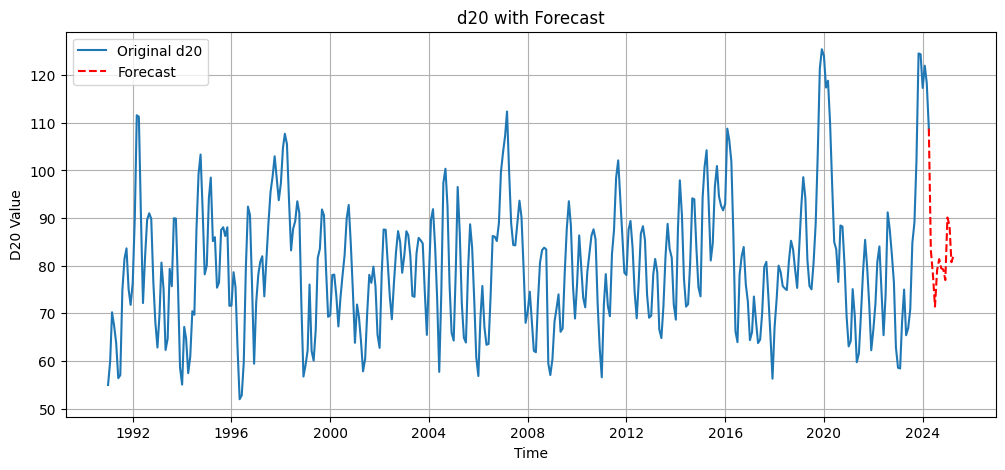

In [51]:
# Check the time coordinates of the original d20 data
original_time = d20.time.values

# The start time of forecast_y_pred is one month after the last time of the original d20 data
forecast_start_time = pd.Timestamp(original_time[-1]) + pd.DateOffset(months=1)

forecast_time = pd.date_range(start=forecast_start_time, periods=len(forecast_y_pred), freq='MS')

# Create a new time coordinate array by combining the original d20 time and forecast_y_pred time
new_time = np.concatenate([original_time, forecast_time])

# Combine the original d20 data and forecast_y_pred
combined_data = np.concatenate([d20.values, forecast_y_pred])

# Create a new xarray DataArray with the combined data
d20_final = xr.DataArray(combined_data, coords=[new_time], dims=["time"], name="d20_forecasted")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(d20.time, d20, label='Original d20')
plt.plot(forecast_time, forecast_y_pred, 'r--', label='Forecast')
plt.plot([d20.time[-1].values, forecast_time[0]], [d20.values[-1], forecast_y_pred[0]], 'r--')
plt.title('d20 with Forecast')
plt.xlabel('Time')
plt.ylabel('D20 Value')
plt.legend()
plt.grid()
plt.show()

In [55]:
d20

<xarray.DataArray 'D20_SCTR' (time: 400)> Size: 3kB
array([ 54.96064 ,  59.899442,  70.225124, ..., 121.968669, 118.355688,
       108.767079])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2024-04-01
Attributes:
    long_name:      d20 at 50E-70E, 10S-5S
    long_name_mod:  Z=0:5500

In [54]:
print(forecast_time)
print(forecast_y_pred)

DatetimeIndex(['2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', freq='MS')
[83.2011   78.04591  71.41928  79.0256   81.375946 79.47368  79.19264
 76.990425 90.10909  88.45493  80.73405  82.1145  ]
